In [ ]:
from netpyne import specs, sim
import netpyne as netpy
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import math
import netpyne
import numba

: 

# things to to in the code

<s>1. the network needs to run without external stimulus:

a. set the initial stimulus,

b. configure sinaptic connections

c. record spikes for 1 second and see if the network stops or tends to stop </s>

2. Configure the external stimulus

a. Configure the extracelular stimulus

<s> b. see if it works with the raster plot </s>

<s> 3. Configure LFP recording with the NetPyNE method </s>

4. extract and analyse spike train data - see how to do that in NetPyNe

5. mesuring sinchronicity of a spiking neural network 

a. with kuramoto model

b. periodogram

In [82]:
# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

## Cell parameters
netParams.cellParams['pyr'] = {
    'secs': {
        'soma': {
            'geom': {
                'diam': 18.8,   
                'L': 18.8, 
                'Ra': 123.0},
            'mechs': {
                'hh': {
                    'gnabar': 0.12, 
                    'gkbar': 0.036, 
                    'gl': 0.0003, 
                    'el': -70}
            }
        },
        'dend1': {
            'geom': {
                'diam': 5.0, 
                'L': 75.0, 
                'Ra': 150.0, 
                'cm': 1
            }, 
            'mechs' :{
                'pas':{
                    'g': 0.0000357, 
                    'e': -70}
            },
            'topol' : {
                'parentSec': 'soma', 
                'parentX': 1.0, 
                'childX': 0
                }
        },
        'dend2': {
            'geom': {
                'diam': 5.0, 
                'L': 75.0, 
                'Ra': 150.0, 
                'cm': 1
            }, 
            'mechs' :{
                'pas':{
                    'g': 0.0000357, 
                    'e': -70}
            },
            'topol' : {
                'parentSec': 'dend1', 
                'parentX': 1.0, 
                'childX': 0
                }
            
        }
    },
    "pt3d": True
}

## Population parameters
netParams.popParams['E'] = { #xyzRange = [0, 100]
    'cellType': 'pyr', 
    'numCells': 80}

netParams.popParams['I'] = {
    'cellType': 'pyr', 
    'numCells': 20}

## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {
    'mod': 'Exp2Syn', 
    'tau1': 0.1, 
    'tau2': 5.0, 
    'e': 0}  # excitatory synaptic mechanism

netParams.synMechParams['inh'] = {
    'mod': 'Exp2Syn', 
    'tau1': 0.1, 
    'tau2': 5.0, 
    'e': -80}  # excitatory synaptic mechanism

# Stimulation parameters
netParams.stimSourceParams['bkg'] = {
    'type': 'NetStim', 
    'rate': 1, #hz 
    'noise': 0.5}

netParams.stimTargetParams['bkg->E'] = {
    'source': 'bkg', 
    'conds': {'pop': 'E'}, 
    'weight': 0.01, 
    'delay': 1,
    'synMech': 'exc'}

## Connectivity rules
netParams.connParams['E->E'] = {    #  label
    'preConds': {'pop': 'E'},       # conditions of presyn cells
    'postConds': {'pop': 'E'},      # conditions of postsyn cells
    'divergence': 5,                # probability of connection
    'weight': 0.01,                 # synaptic weight
    'delay': 5,                     # transmission delay (ms)
    'synMech': 'exc'}               # synaptic mechanism

netParams.connParams['E->I'] = {    #  label
    'preConds': {'pop': 'E'},       # conditions of presyn cells
    'postConds': {'pop': 'I'},      # conditions of postsyn cells
    'divergence': 5,                # probability of connection
    'weight': 0.01,                 # synaptic weight
    'delay': 5,                     # transmission delay (ms)
    'synMech': 'exc'}               # synaptic mechanism

netParams.connParams['I->E'] = {    #  label
    'preConds': {'pop': 'I'},       # conditions of presyn cells
    'postConds': {'pop': 'E'},      # conditions of postsyn cells
    'divergence': 10,               # probability of connection
    'weight': 0.01,                 # synaptic weight
    'delay': 5,                     # transmission delay (ms)
    'synMech': 'inh'}               # synaptic mechanism

simConfig = specs.SimConfig()       # object of class SimConfig to store simulation configuration



In [83]:
# #------------------------------------------------------------------------------
# #  extracellular mechs
# #------------------------------------------------------------------------------
for celltyp in netParams.cellParams.keys():
    label = []
    for secname in netParams.cellParams[celltyp]['secs'].keys():
        netParams.cellParams[celltyp]['secs'][secname]['mechs']['extracellular'] = {}


In [84]:
netParams.cellParams

{pyr: {'secs': {'soma': {'geom': {'diam': 18.8, 'L': 18.8, 'Ra': 123.0}, 'mechs': {'hh': {'gnabar': 0.12, 'gkbar': 0.036, 'gl': 0.0003, 'el': -70}, 'extracellular': {}}}, 'dend1': {'geom': {'diam': 5.0, 'L': 75.0, 'Ra': 150.0, 'cm': 1}, 'mechs': {'pas': {'g': 3.57e-05, 'e': -70}, 'extracellular': {}}, 'topol': {'parentSec': 'soma', 'parentX': 1.0, 'childX': 0}}, 'dend2': {'geom': {'diam': 5.0, 'L': 75.0, 'Ra': 150.0, 'cm': 1}, 'mechs': {'pas': {'g': 3.57e-05, 'e': -70}, 'extracellular': {}}, 'topol': {'parentSec': 'dend1', 'parentX': 1.0, 'childX': 0}}}, 'pt3d': True}}

In [85]:

# Simulation options

simConfig.duration = 1500          # Duration of the simulation, in ms
simConfig.dt = 0.01                # Internal integration timestep to use
simConfig.verbose = False           # Show detailed messages
simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
simConfig.recordCells = ['E', 'I']
simConfig.recordStep = 0.1          # Step size in ms to save data (eg. V traces, LFP, etc)
simConfig.filename = 'raster'  # Set file output name
simConfig.saveJson = False
simConfig.recordLFP = [[50,50,50]]

#simConfig.analysis['plotTraces'] = {'include': ['E', 'I'], 'saveFig': True}  # Plot recorded traces for this list of cells
simConfig.analysis['plotRaster'] = {'showFig': True}                  # Plot a raster
simConfig.analysis['plotSpikeHist'] = {'include': ['E', 'I'], 'showFig': True}
simConfig.analysis['plot2Dnet'] = {'saveFig': True}                   # plot 2D cell positions and connections
# simConfig.analysis['plotRateSpectrogram'] = {'include': ['all'], 'saveFig': True}
#simConfig.analysis['recordLFP'] = [[50,50,50]]


# Create network and run simulation
# sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig)    

In [86]:
import neuron

sim.initialize(
    simConfig = simConfig, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations


Start time:  2024-01-24 18:59:16.935154

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 100 
  Done; cell creation time = 0.02 s.


[compartCell0,
 compartCell1,
 compartCell2,
 compartCell3,
 compartCell4,
 compartCell5,
 compartCell6,
 compartCell7,
 compartCell8,
 compartCell9,
 compartCell10,
 compartCell11,
 compartCell12,
 compartCell13,
 compartCell14,
 compartCell15,
 compartCell16,
 compartCell17,
 compartCell18,
 compartCell19,
 compartCell20,
 compartCell21,
 compartCell22,
 compartCell23,
 compartCell24,
 compartCell25,
 compartCell26,
 compartCell27,
 compartCell28,
 compartCell29,
 compartCell30,
 compartCell31,
 compartCell32,
 compartCell33,
 compartCell34,
 compartCell35,
 compartCell36,
 compartCell37,
 compartCell38,
 compartCell39,
 compartCell40,
 compartCell41,
 compartCell42,
 compartCell43,
 compartCell44,
 compartCell45,
 compartCell46,
 compartCell47,
 compartCell48,
 compartCell49,
 compartCell50,
 compartCell51,
 compartCell52,
 compartCell53,
 compartCell54,
 compartCell55,
 compartCell56,
 compartCell57,
 compartCell58,
 compartCell59,
 compartCell60,
 compartCell61,
 compartCell62,
 c

In [87]:
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.net.defineCellShapes()

Making connections...
  Number of connections on node 0: 1000 
  Done; cell connection time = 0.17 s.
Adding stims...
  Number of stims on node 0: 80 
  Done; cell stims creation time = 0.02 s.
Recording 100 traces of 1 types on node 0


In [88]:
# The parameters of the extracellular point current source
acs_params = {'position': [20.0, 20.0, 20.0],  # um
              'amp': 50.,  # uA,
              'stimstart': 0,  # ms
              'stimend': 1500,  # ms
              'frequency': 10,  # Hz
              'sigma': 0.57  # decay constant S/m
              }

skull_attenuation = 0.01*710 #conductivity of bone(S/m) * thickness of rat skull um

def insert_v_ext(cell, v_ext, v_ext1, v_ext2, t_ext):

    cell.t_ext = neuron.h.Vector(t_ext)
    cell.v_ext = []
    cell.v_ext1 = []
    cell.v_ext2 = []
    for s,d1,d2 in zip(v_ext,v_ext1, v_ext2):
        cell.v_ext.append(neuron.h.Vector(s))
        cell.v_ext1.append(neuron.h.Vector(d1))
        cell.v_ext2.append(neuron.h.Vector(d2))

    # play v_ext into e_extracellular reference
    i = 0
    cell.v_ext[i].play(cell.secs['soma']['hObj'](0.5)._ref_e_extracellular, cell.t_ext)
    cell.v_ext1[i].play(cell.secs['dend1']['hObj'](0.5)._ref_e_extracellular, cell.t_ext)
    cell.v_ext2[i].play(cell.secs['dend2']['hObj'](0.5)._ref_e_extracellular, cell.t_ext)


def make_extracellular_stimuli0(acs_params, cell):
    """ Function to calculate and apply external potential """
    x0, y0, z0 = acs_params['position']
    ext_field = np.vectorize(lambda x, y, z: 1 / (4 * np.pi *
                                                  (acs_params['sigma'] * 
                                                   np.sqrt((x0 - x)**2 + (y0 - y)**2 + (z0 - z)**2) + skull_attenuation)))

    stimstart = acs_params['stimstart']
    stimend = acs_params['stimend']
    stimdif = stimend-stimstart

    # MAKING THE EXTERNAL FIELD
    n_tsteps = int(stimdif / simConfig.dt + 1)
    n_start = int(stimstart/simConfig.dt)
    n_end = int(stimend/simConfig.dt + 1)
    t = np.arange(start=n_start, stop=n_end) * simConfig.dt
    pulse = acs_params['amp'] * 1000. * \
          np.sin(2 * np.pi * acs_params['frequency'] * t / 1000)
        
        
    v_cell_ext = np.zeros((1, n_tsteps))
    v_cell_ext1 = np.zeros((1, n_tsteps))
    v_cell_ext2 = np.zeros((1, n_tsteps))
    
    v_cell_ext[:, :] = ext_field(cell.getSomaPos()[0], abs(cell.getSomaPos()[1]), cell.getSomaPos()[2]).reshape(1, 1) * pulse.reshape(1, n_tsteps)
    # v_cell_ext1[:, :] = ext_field(cell.getDend1Pos()[0], abs(cell.getDend1Pos()[1]), cell.getDend1Pos()[2]).reshape(1, 1) * pulse.reshape(1, n_tsteps)
    # v_cell_ext2[:, :] = ext_field(cell.getDend2Pos()[0], abs(cell.getDend2Pos()[1]), cell.getDend2Pos()[2]).reshape(1, 1) * pulse.reshape(1, n_tsteps)

    insert_v_ext(cell, v_cell_ext, v_cell_ext1, v_cell_ext2 , t)

    return ext_field, pulse

def make_extracellular_stimuli(dbs_params, cell):
    """ Function to calculate and apply external potential """
    x0, y0, z0 = dbs_params['position']
    sigma = 0.3
    ext_field = np.vectorize(lambda x,y,z: 1 / (4 * np.pi* sigma * np.sqrt(
        (x0 - x)**2 + (y0 - y)**2 + (z0 - z)**2)))
    
    stimstart = acs_params['stimstart']
    stimend = acs_params['stimend']
    stimdif = stimend-stimstart

    ### MAKING THE EXTERNAL FIELD
    n_tsteps = int(stimdif / simConfig.dt + 1)
    t = np.arange(n_tsteps) * simConfig.dt
    pulse = np.zeros(n_tsteps)
    start_time = dbs_params['stimstart']
    end_time = dbs_params['stimend']
    start_idx = np.argmin(np.abs(t - start_time))
    end_idx = np.argmin(np.abs(t - end_time))
    pulse[start_idx:end_idx] = dbs_params['amp'] * 1000.

    v_cell_ext = np.zeros((3, n_tsteps)) # 3 in here is soma dend1 and dwend2
    v_cell_ext[:, :] = ext_field(cell.x.mean(axis=-1), cell.y.mean(axis=-1), cell.z.mean(axis=-1)
                                 ).reshape(cell.totnsegs, 1) * pulse.reshape(1, n_tsteps)
    cell.insert_v_ext(v_cell_ext, t)
    return ext_field, pulse

#Add extracellular stim
for c,metype in enumerate(sim.net.cells):
    if 'presyn' not in metype.tags['pop']:
        ext_field, pulse = make_extracellular_stimuli(acs_params, sim.net.cells[c])

sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc


AttributeError: 'CompartCell' object has no attribute 'x'

Preparing LFP data...
Plotting LFP time series...
Preparing LFP data...
Preparing PSD data...
Plotting LFP power spectral density (PSD)...
Preparing LFP data...
Preparing spectrogram data...
Plotting LFP spectrogram...
Plotting LFP electrode locations...
Plotting 3D cell shape ...

There was an exception in plotShape()

There was an exception in plotLFPLocations()


Traceback (most recent call last):
  File "C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\netpyne\analysis\utils.py", line 87, in wrapper
    return function(*args, **kwargs)
  File "C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\netpyne\plotting\plotShape.py", line 192, in plotShape
    shapeax.dist = dist * shapeax.dist
AttributeError: 'Axes3D' object has no attribute 'dist'
Traceback (most recent call last):
  File "C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\netpyne\analysis\utils.py", line 87, in wrapper
    return function(*args, **kwargs)
  File "C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\netpyne\plotting\plotL

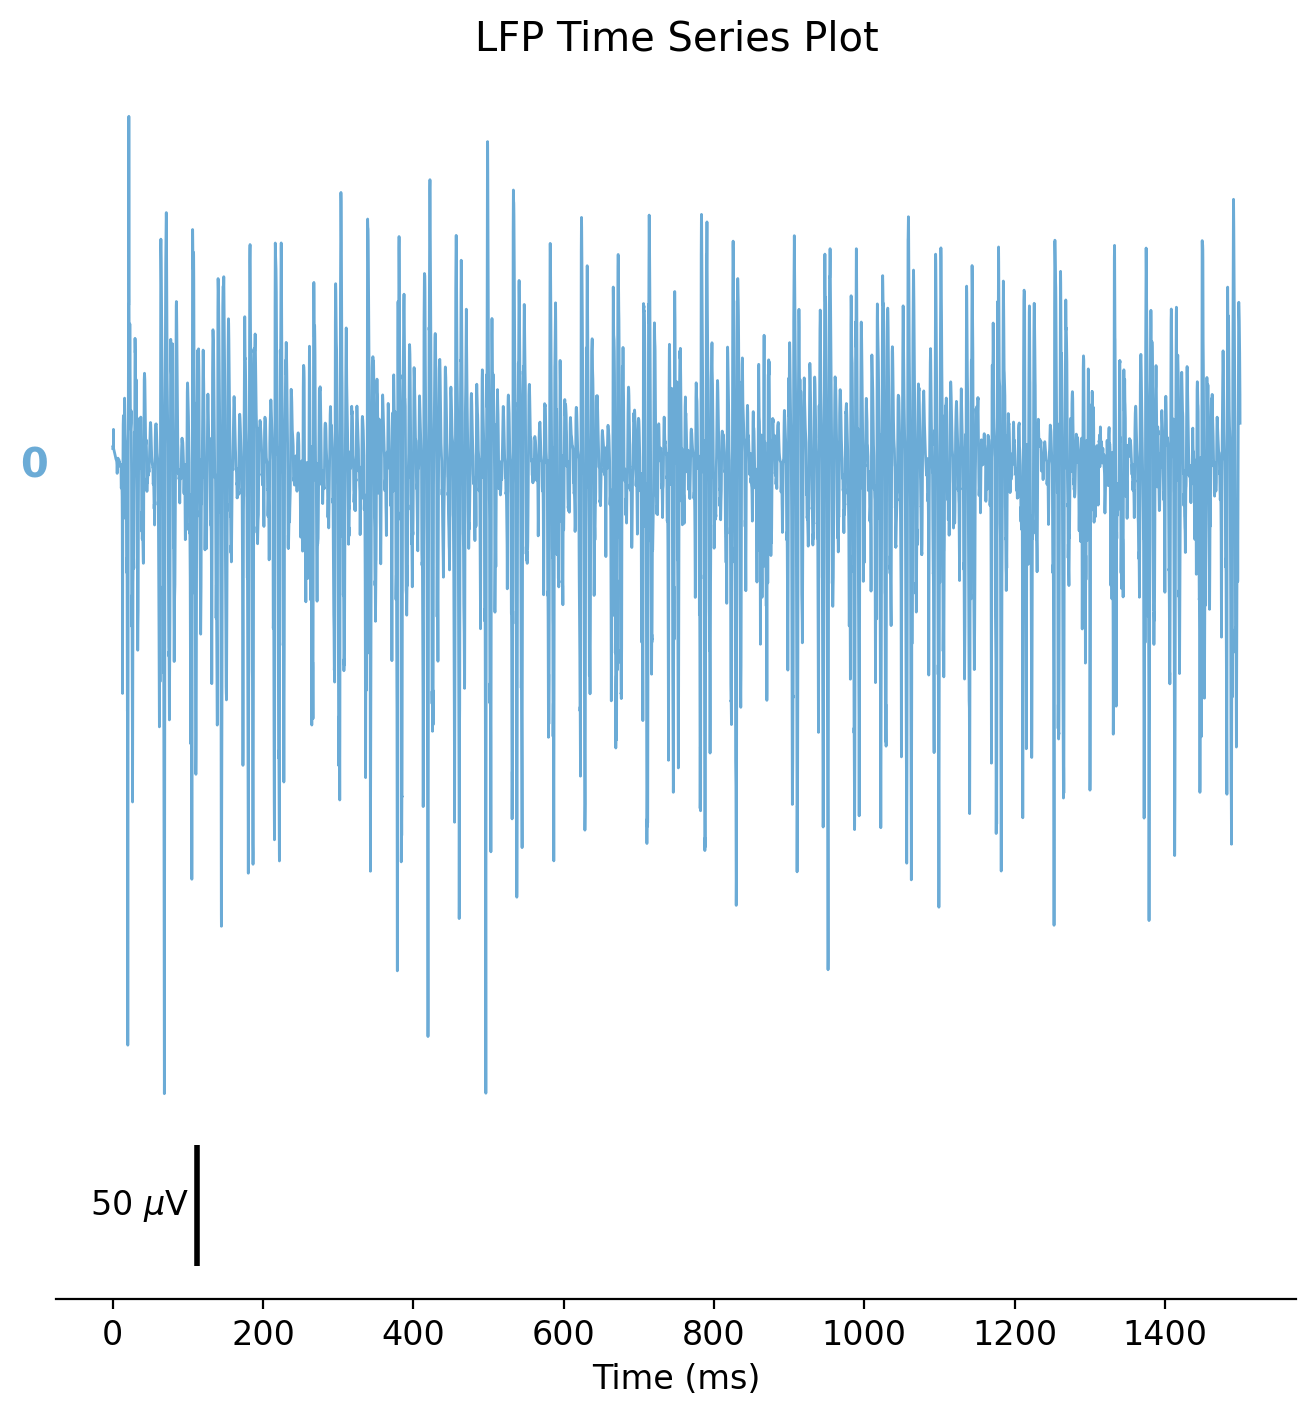

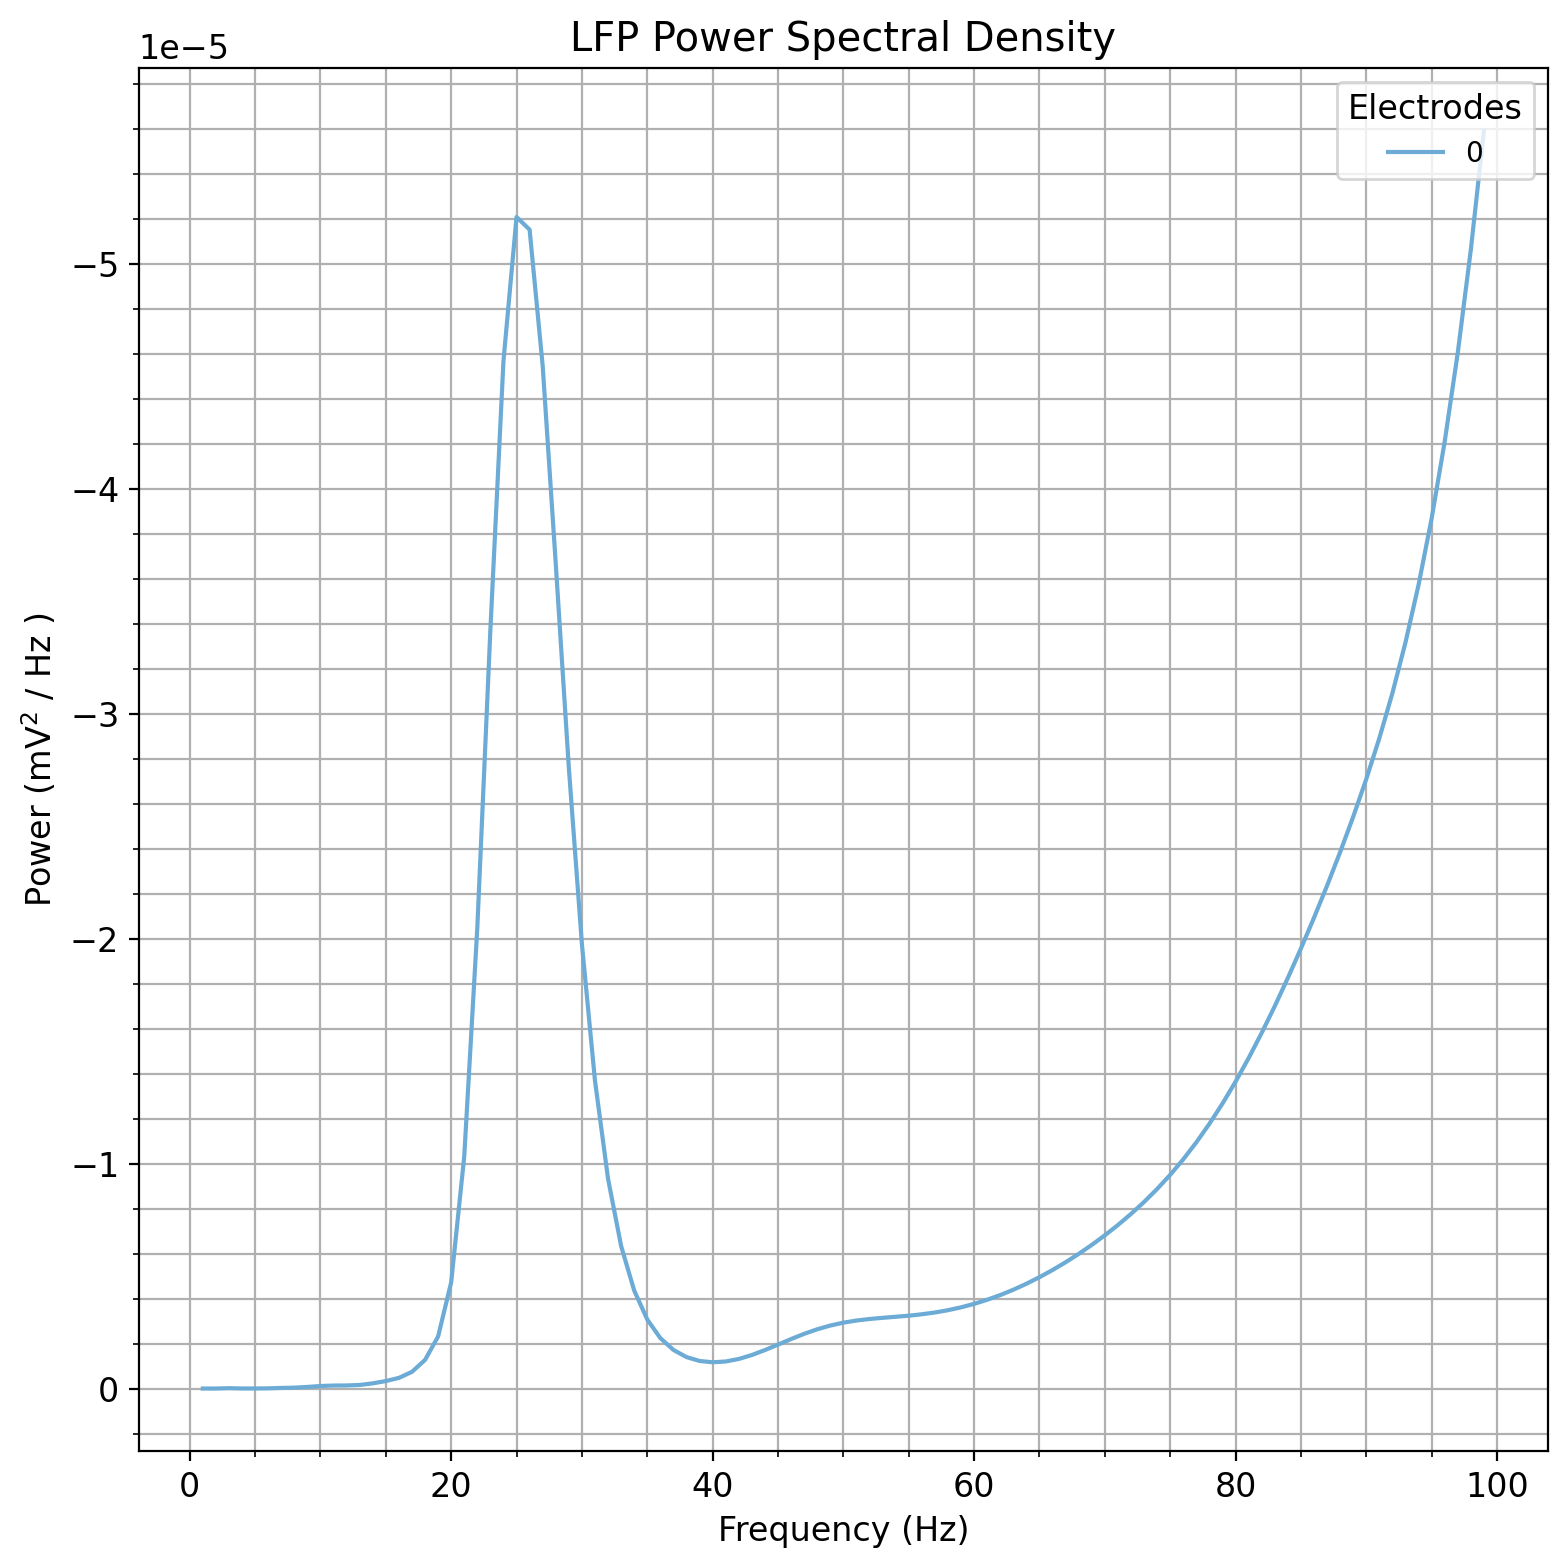

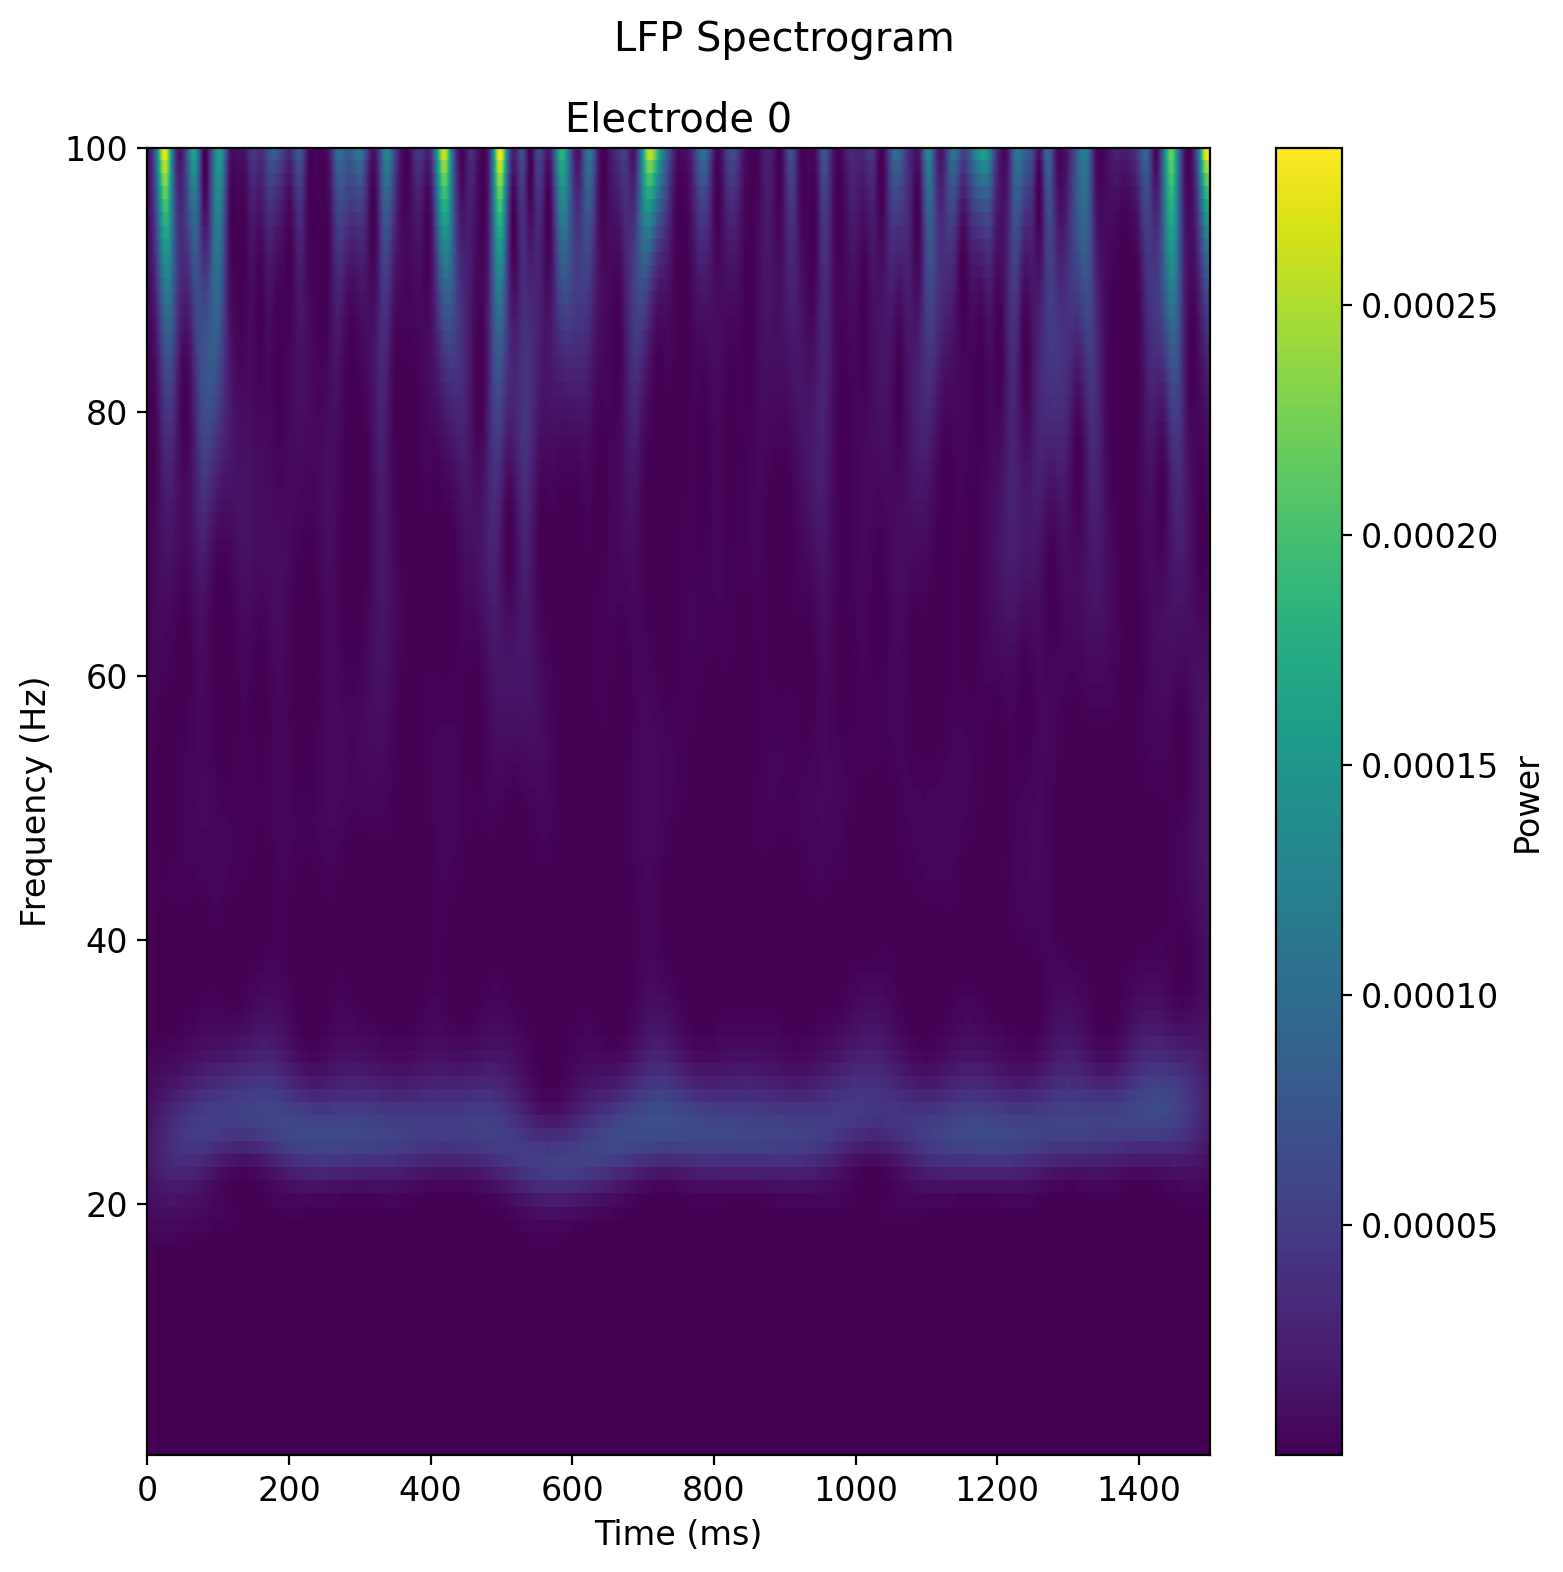

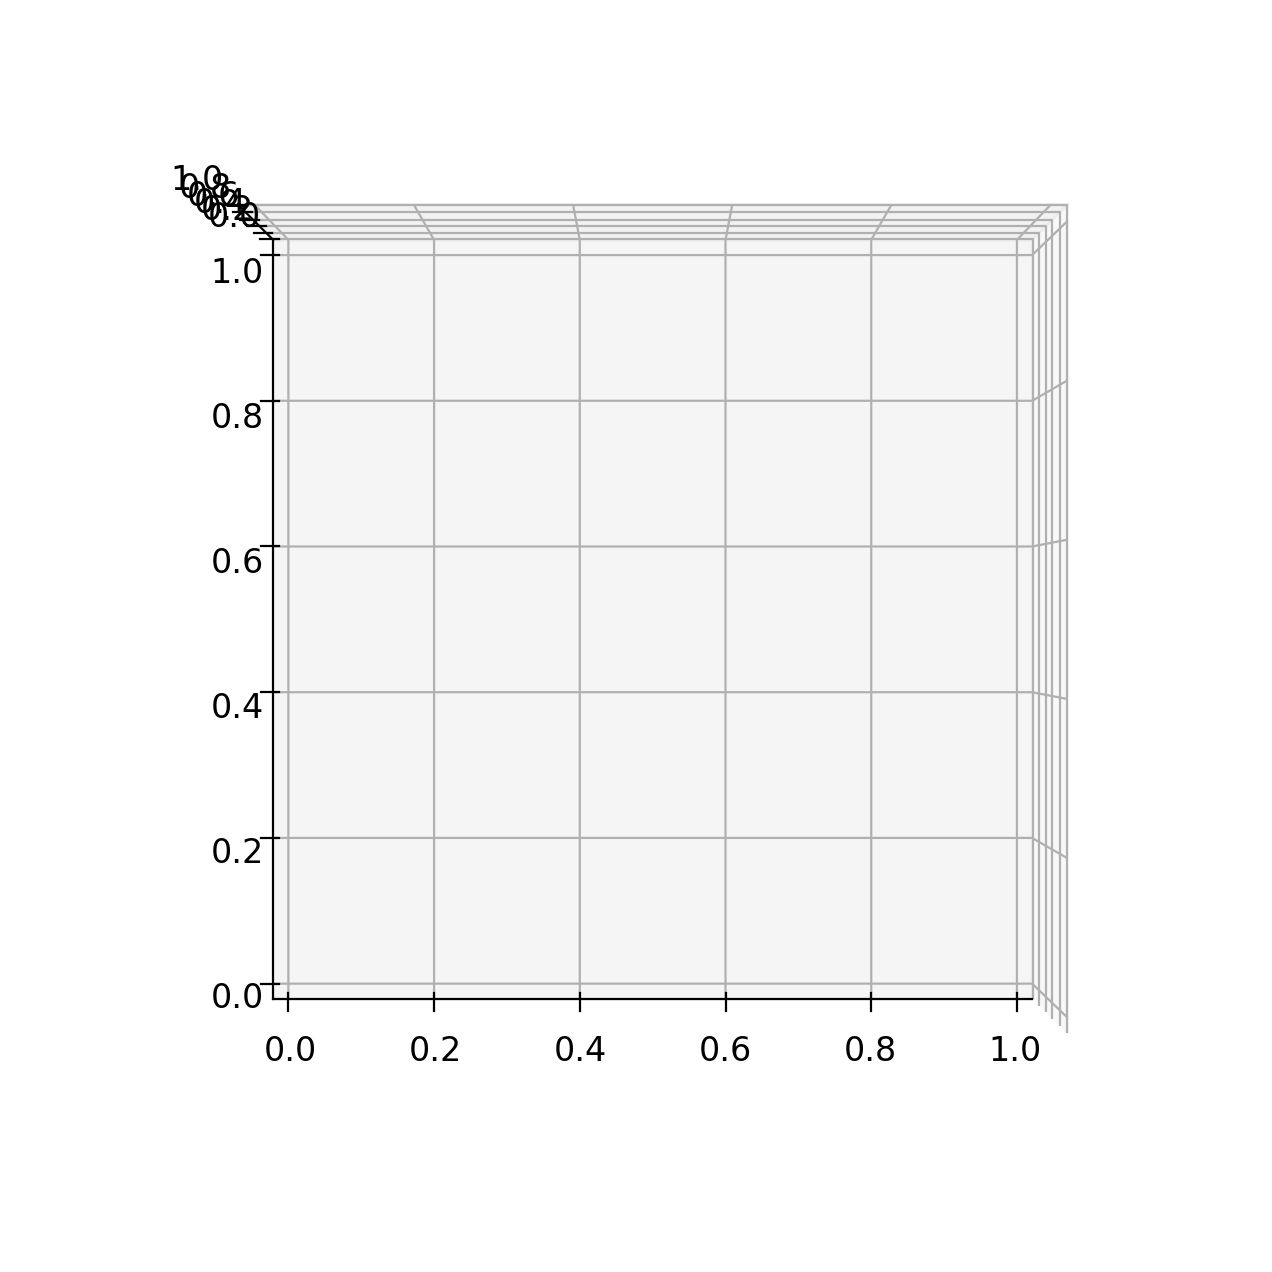

In [ ]:
sim.analysis.plotLFP(electrodes=[0])

In [ ]:
#sim.analysis.plotTraces()

Plotting 3D cell shape ...

There was an exception in plotShape()


Traceback (most recent call last):
  File "C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\netpyne\analysis\utils.py", line 87, in wrapper
    return function(*args, **kwargs)
  File "C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\netpyne\plotting\plotShape.py", line 192, in plotShape
    shapeax.dist = dist * shapeax.dist
AttributeError: 'Axes3D' object has no attribute 'dist'


-1

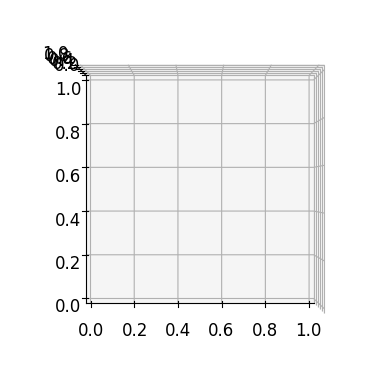

In [ ]:
sim.analysis.plotShape(showFig = True,  cvar='voltage')

In [ ]:
sim.simData['spkid'].to_python()
sim.simData['spkt'].to_python()
sim.simData['LFP']

array([[0.00732005],
       [0.00833474],
       [0.00841018],
       ...,
       [0.03456527],
       [0.02943261],
       [0.01774041]])

In [ ]:


# sim.net.cells[0].getDendPos()

sim.net.cells[0].nsegs

# netParams.cellParams[celltyp]['secs'].keys()

AttributeError: 'CompartCell' object has no attribute 'nsegs'

In [1]:
import metrics_Kuramoto as kura

ModuleNotFoundError: No module named 'numba'